In [142]:
import os
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec
import json
import torch

from bnn_priors.exp_utils import load_samples
from bnn_priors.notebook_utils import collect_runs
from bnn_priors import plot
from gpytorch.distributions import MultivariateNormal
from gpytorch.lazy import DiagLazyTensor
import seaborn as sns

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

## Define functions

In [2]:
# Adapted from https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

import scipy.stats as st
import warnings
import tqdm
from sklearn.mixture import GaussianMixture

# Create models from data
def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    #DISTRIBUTIONS = [st.cauchy,st.gennorm,st.laplace,st.norm,st.t]
    DISTRIBUTIONS = [st.laplace,st.norm,st.t]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    
    sses = {}

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                sses[distribution.name] = sse

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            f"Failed to fit {distribution}"

    return (best_distribution.name, best_params, sses)


def make_pdf(dist, params, size=1000, start=None, end=None):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    if start is None:
        start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    if end is None:
        end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [3]:
def plot_weightdist(weights, title=None, num_bins=50):
    fig, axes = plt.subplots(ncols=2, figsize=(8,3))
    vmin = np.min([weight for weight in weights.values()])
    vmax = np.max([weight for weight in weights.values()])
    xlim = (vmin, vmax)
    for (name, weight), ax in zip(weights.items(), axes):
        sns.distplot(weight.flatten(), ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
        gauss_pdf = make_pdf(stats.norm, stats.norm.fit(weight), start=xlim[0], end=xlim[1])
        sns.lineplot(data=gauss_pdf, label=r"gaussian\_fit", ax=ax)
        ax.legend(loc="upper right")
        ax.set_xlim(xlim)
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [4]:
def plot_covariance(weights_reshaped, rowvar, title=None, rasterized=None):
    fig = plt.figure(figsize=(9,4))
    grid = gridspec.GridSpec(nrows=1,ncols=3,figure=fig,width_ratios=[20,20,1])
    axes = [plt.subplot(spec) for spec in grid]
    vmin = np.min([np.cov(weight, rowvar=rowvar) for weight in weights_reshaped.values()])
    vmax = np.max([np.cov(weight, rowvar=rowvar) for weight in weights_reshaped.values()])
    rasterized_orig = rasterized
    for (name, weight), ax in zip(weights_reshaped.items(), axes):
        cov =np.cov(weight, rowvar=rowvar)
        if rasterized_orig is None:
            rasterized = (True if cov.shape[0] > 19 else False)
        sns.heatmap(cov, cmap="Blues", ax=ax, vmin=vmin, vmax=vmax, cbar=(name=="empirical"), cbar_ax=axes[2],
                   rasterized=rasterized)
        ax.set_xlabel(name)
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [5]:
def plot_covar_offdiagonals(weights_reshaped, rowvar, title=None, num_bins=50):
    fig, axes = plt.subplots(ncols=2, figsize=(8,3))
    vmin = np.min([np.cov(weight, rowvar=rowvar) for weight in weights_reshaped.values()])
    xlim = (vmin,-vmin)
    for (name, weight), ax in zip(weights_reshaped.items(), axes):
        covar = np.cov(weight, rowvar=rowvar)
        offdiagonals = covar[np.where(~np.eye(covar.shape[0],dtype=bool))]
        sns.distplot(offdiagonals, ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
        ax.set_xlim(xlim)
        gauss_pdf = make_pdf(stats.norm, stats.norm.fit(offdiagonals), start=xlim[0], end=xlim[1])
        sns.lineplot(data=gauss_pdf, label=r"gaussian\_fit", ax=ax)
        ax.legend(loc="upper right")
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [6]:
def plot_covar_offdiagonals_reduced(weights_reshaped, rowvar, title=None, num_bins=50, ax=None, legend=True):
    print("legend", legend)
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,3))
    else:
        fig = None
    vmin = np.min([np.cov(weight, rowvar=rowvar) for weight in weights_reshaped.values()])
    xlim = (vmin,-vmin)
    for name in ["empirical", "gaussian"]:
        weight = weights_reshaped[name]
        covar = np.cov(weight, rowvar=rowvar)
        offdiagonals = covar[np.where(~np.eye(covar.shape[0],dtype=bool))]
        if name == "empirical":
            sns.distplot(offdiagonals, ax=ax, bins=num_bins, kde=False, norm_hist=True)
            ax.set_xlabel(name)
            ax.set_xlim(xlim)
        else:
            gauss_pdf = make_pdf(stats.norm, stats.norm.fit(offdiagonals), start=xlim[0], end=xlim[1])
            ax.plot(gauss_pdf.index, gauss_pdf.values, label=r"ind. Gaussian cov. entries")
            if legend:
                ax.legend(loc="upper right")
        ax.tick_params(left=False, labelleft=False)

    if fig is not None:
        if title is not None:
            fig.suptitle(title)
            fig.tight_layout(rect=[0, 0, 1, 0.97])
        else:
            fig.tight_layout()
    return fig

In [7]:
def plot_singular_values(weights_reshaped, title=None, num_bins=10):
    fig, axes = plt.subplots(ncols=2, figsize=(8,3))
    for (name, weight), ax in zip(weights_reshaped.items(), axes):
        _, singvals, _ = np.linalg.svd(weight)
        sns.distplot(singvals, ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [8]:
def generate_all_figures(state_dict, exp_name, cnn=True):
    if cnn:
        num_channels = 4
    else:
        num_channels = 2
    with PdfPages(f"../figures/{exp_name}_weight_distributions.pdf") as pdf:
        for param, weight_values in state_dict.items():
            if "weight_prior.p" in param and len(weight_values.shape) == num_channels:
                layer = param.split("weight_prior.p")[0]
                print(layer)

                weight = weight_values.numpy()
                weight_gaussian = np.random.normal(loc=weight.mean(), scale=weight.std(), size=weight.shape)
                weights = {"gaussian": weight_gaussian, "empirical": weight}
                weights_reshaped = {name : weight.reshape(weight.shape[0], -1) for name, weight in weights.items()}

                fig = plot_weightdist(weights, title=f"{layer}weight_distribution")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covariance(weights_reshaped, False, title=f"{layer}covariance_inputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covariance(weights_reshaped, True, title=f"{layer}covariance_outputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covar_offdiagonals(weights_reshaped, False, title=f"{layer}covar_offdiag_inputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covar_offdiagonals(weights_reshaped, True, title=f"{layer}covar_offdiag_outputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_singular_values(weights_reshaped, title=f"{layer}singular_values")
                pdf.savefig()
                plt.close(fig)
    print("done!")

## Generate plots for paper

In [9]:
import h5py
import collections


def load_many_samples(path, directories=range(8)):
    param_keys = None
    samples = collections.defaultdict(lambda: [], {})

    for d in map(str, directories):
        with h5py.File(path + f"/{d}/samples.pt", "r") as f:
            if param_keys is None:
                param_keys = [k for k in f.keys() if k.endswith(".p")]

            for key in param_keys:
                samples[key].append(f[key][-1])
    for k in samples.keys():
        samples[k] = np.stack(samples[k])
    return samples

def reshape_weight(weight, f):
    weight = f(weight)
    weight_gaussian = np.random.normal(loc=weight.mean(), scale=weight.std(), size=weight.shape)
    return {"gaussian": weight_gaussian, "empirical": weight}

In [10]:
all_samples = {}

#### MNIST CNN

In [11]:
exp_name = "mnist_classificationconvnet"

In [12]:
samples = load_many_samples(f"../logs/sgd-no-weight-decay/{exp_name}/")

all_samples[exp_name] = samples

exp_name = "201110_"+exp_name

NameError: name 'sns' is not defined

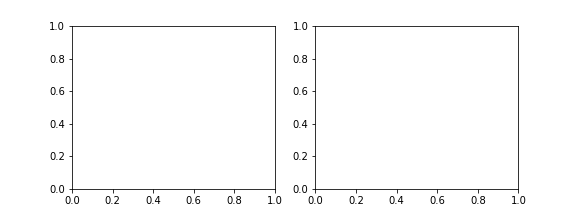

In [13]:
key = "net.module.1.weight_prior.p"

fig = plot_weightdist(reshape_weight(samples[key], lambda x: x), num_bins=25)

In [ ]:
def reshape_input_covar(weights):
    return reshape_weight(weights, lambda w: w.transpose((0, 1, 2, 3, 4)).reshape((w.shape[0]*w.shape[1], -1)))
def reshape_output_covar(weights):
    return reshape_weight(weights, lambda w: w.transpose((0, 2, 3, 4, 1)).reshape((-1, w.shape[1])))

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_weightdist.pdf")

In [ ]:
fig = plot_covariance(reshape_input_covar(samples[key]),  rowvar=False)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_covar_inputs.pdf")

In [ ]:
fig = plot_covariance(reshape_output_covar(samples[key]),  rowvar=False)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_covar_outputs.pdf")

In [ ]:
fig = plot_covar_offdiagonals(reshape_input_covar(samples[key]), rowvar=False, num_bins=10)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_input.pdf")

In [ ]:
fig = plot_covar_offdiagonals(reshape_output_covar(samples[key]), rowvar=False, num_bins=30)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_output.pdf")

In [ ]:
fig = plot_covar_offdiagonals_reduced(reshape_output_covar(samples[key]), rowvar=False, num_bins=30)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_output_reduced.pdf")

In [ ]:
fig = plot_covar_offdiagonals_reduced(reshape_input_covar(samples[key]), rowvar=False, num_bins=30)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_input_reduced.pdf")

In [ ]:
fig = plot_singular_values(reshape_output_covar(samples[key]), num_bins=10)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_singvals.pdf")

In [ ]:
key = "net.module.4.weight_prior.p"

In [ ]:

fig = plot_weightdist(reshape_weight(samples[key], lambda x: x), num_bins=25)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_weightdist.pdf")

In [ ]:
fig = plot_covariance(reshape_input_covar(samples[key]),  rowvar=False)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_covar_inputs.pdf")

In [ ]:
fig = plot_covariance(reshape_output_covar(samples[key]),  rowvar=False)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_covar_outputs.pdf")

In [ ]:
fig = plot_covar_offdiagonals(reshape_input_covar(samples[key]), rowvar=False, num_bins=50)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_input.pdf")

In [ ]:
fig = plot_covar_offdiagonals(reshape_output_covar(samples[key]), rowvar=False, num_bins=50)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_output.pdf")

In [ ]:
fig = plot_covar_offdiagonals_reduced(reshape_output_covar(samples[key]), rowvar=False, num_bins=50)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_output_reduced.pdf")

In [ ]:
fig = plot_covar_offdiagonals_reduced(reshape_input_covar(samples[key]), rowvar=False, num_bins=50)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_input_reduced.pdf")

In [ ]:
fig = plot_singular_values(reshape_output_covar(samples[key]), num_bins=10)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_singvals.pdf")

In [ ]:
samples [key].shape

In [ ]:
weights_reshaped = {name : weight.reshape(-1, 9) for name, weight in reshape_weight(samples[key], lambda w: w).items()}

In [ ]:
fig = plot_covariance(weights_reshaped, rowvar=False)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_covar_channels.pdf")

In [ ]:
fig = plot_covar_offdiagonals_reduced(weights_reshaped, rowvar=False, num_bins=15)
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_spatial_reduced.pdf")

#### MNIST feedforward

In [19]:
exp_name = "mnist_classificationdensenet"

In [20]:
samples = load_many_samples(f"../logs/sgd-no-weight-decay/{exp_name}/", filter(lambda x: x != 5, range(10)))
all_samples[exp_name] = samples

exp_name = "201110_"+exp_name

NameError: name 'sns' is not defined

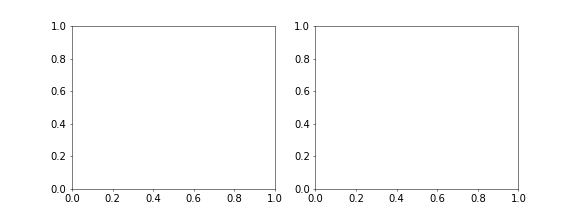

In [21]:
key = "net.module.0.weight_prior.p"

fig = plot_weightdist(reshape_weight(samples[key], lambda x: x), num_bins=30)

In [ ]:
def reshape_input_covar(weights):
    return reshape_weight(weights, lambda w: w.transpose((0, 1, 2)).reshape((w.shape[0]*w.shape[1], -1)))
def reshape_output_covar(weights):
    return reshape_weight(weights, lambda w: w.transpose((0, 2, 1)).reshape((-1, w.shape[1])))

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_weightdist.pdf")

In [ ]:
fig = plot_covariance(reshape_input_covar(samples[key]),  rowvar=False)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_covar_inputs.pdf")

In [ ]:
fig = plot_covariance(reshape_output_covar(samples[key]),  rowvar=False)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_covar_outputs.pdf")

In [ ]:
fig = plot_covar_offdiagonals(reshape_input_covar(samples[key]), rowvar=False, num_bins=40)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_input.pdf")

In [ ]:
fig = plot_covar_offdiagonals(reshape_output_covar(samples[key]), rowvar=False, num_bins=30)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_output.pdf")

In [ ]:
fig = plot_covar_offdiagonals_reduced(reshape_output_covar(samples[key]), rowvar=False, num_bins=30)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_output_reduced.pdf")

In [ ]:
fig = plot_covar_offdiagonals_reduced(reshape_input_covar(samples[key]), rowvar=False, num_bins=50)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_offdiag_input_reduced.pdf")

In [ ]:
fig = plot_singular_values(reshape_output_covar(samples[key]), num_bins=10)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer1_singvals.pdf")

In [ ]:
key = "net.module.2.weight_prior.p"

In [ ]:

fig = plot_weightdist(reshape_weight(samples[key], lambda x: x), num_bins=25)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_weightdist.pdf")

In [ ]:
fig = plot_covariance(reshape_input_covar(samples[key]),  rowvar=False)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_covar_inputs.pdf")

In [ ]:
fig = plot_covariance(reshape_output_covar(samples[key]),  rowvar=False)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_covar_outputs.pdf")

In [ ]:
fig = plot_covar_offdiagonals(reshape_input_covar(samples[key]), rowvar=False, num_bins=50)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_input.pdf")

In [ ]:
fig = plot_covar_offdiagonals(reshape_output_covar(samples[key]), rowvar=False, num_bins=50)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_output.pdf")

In [ ]:
fig = plot_covar_offdiagonals_reduced(reshape_output_covar(samples[key]), rowvar=False, num_bins=50)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_output_reduced.pdf")

In [ ]:
fig = plot_covar_offdiagonals_reduced(reshape_input_covar(samples[key]), rowvar=False, num_bins=50)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_offdiag_input_reduced.pdf")

In [ ]:
fig = plot_singular_values(reshape_output_covar(samples[key]), num_bins=10)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_singvals.pdf")

In [ ]:
weights_reshaped = {name : weight.reshape(-1, 9) for name, weight in reshape_weight(samples[key], lambda w: w).items()}

In [ ]:
fig = plot_covariance(weights_reshaped, rowvar=False)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer2_covar_channels.pdf")

In [ ]:
key = "net.module.4.weight_prior.p"

In [ ]:

fig = plot_weightdist(reshape_weight(samples[key], lambda x: x), num_bins=25)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer3_weightdist.pdf")

In [ ]:
fig = plot_covariance(reshape_input_covar(samples[key]),  rowvar=False)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer3_covar_inputs.pdf")

In [ ]:
fig = plot_covariance(reshape_output_covar(samples[key]),  rowvar=False)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer3_covar_outputs.pdf")

In [ ]:
fig = plot_covar_offdiagonals(reshape_input_covar(samples[key]), rowvar=False, num_bins=50)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer3_offdiag_input.pdf")

In [ ]:
fig = plot_covar_offdiagonals(reshape_output_covar(samples[key]), rowvar=False, num_bins=25)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer3_offdiag_output.pdf")

In [ ]:
fig = plot_covar_offdiagonals_reduced(reshape_output_covar(samples[key]), rowvar=False, num_bins=25)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer3_offdiag_output_reduced.pdf")

In [14]:
fig = plot_covar_offdiagonals_reduced(reshape_input_covar(samples[key]), rowvar=False, num_bins=50)

NameError: name 'reshape_input_covar' is not defined

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer3_offdiag_input_reduced.pdf")

In [ ]:
fig = plot_singular_values(reshape_output_covar(samples[key]), num_bins=10)

In [ ]:
fig.savefig(f"../figures/{exp_name}_layer3_singvals.pdf")

#### Compare weight dists side-by-side

In [231]:
#samples_file = f"../results/200922_mnist_cnn/16/samples.pt"

key = 'net.module.4.weight_prior.p'

w_list = []
for i in range(8):
    samples_file = f"../logs/sgd-no-weight-decay/mnist_classificationconvnet/{i}/samples.pt"
    s = load_samples(samples_file)
    w_list.append(s[key][-1].numpy())
weight_cnn = np.stack(w_list)

In [229]:
#samples_file = f"../results/200917_mnist/18/samples.pt"

key = 'net.module.0.weight_prior.p'


w_list = []
for i in range(10):
    if i ==5 :
        continue
    samples_file = f"../logs/sgd-no-weight-decay/mnist_classificationdensenet/{i}/samples.pt"
    s = load_samples(samples_file)
    w_list.append(s[key][-1].numpy())
weight_dnn = np.stack(w_list)

In [138]:
df = collect_runs("../logs/0_31_googleresnet_cifar10_sgd")
good_runs = df[(df["n_epochs"] == 600) & (df["status"] == "COMPLETED")]
good_runs[good_runs["data"] == "cifar10_augmented"]

,lr,momentum,model,data,width,temperature,weight_decay,sampling_decay,n_epochs,status,the_dir,result.lp_ensemble,result.lp_last,result.acc_ensemble,result.acc_last,result.ece,result.ace,result.rmsce
31,0.05,0.9,googleresnet,cifar10_augmented,64,0.0,0.0,stairs,600,COMPLETED,../logs/0_31_googleresnet_cifar10_sgd/28,-0.616530,-0.655545,0.9028,0.9028,0.073213,0.014624,0.013434
46,0.05,0.9,googleresnet,cifar10_augmented,64,0.0,0.0,stairs,600,COMPLETED,../logs/0_31_googleresnet_cifar10_sgd/43,-0.630715,-0.680964,0.9006,0.9003,0.076470,0.014857,0.013439
67,0.05,0.9,googleresnet,cifar10_augmented,64,0.0,0.0,stairs,600,COMPLETED,../logs/0_31_googleresnet_cifar10_sgd/20,-0.600544,-0.648339,0.9041,0.9040,0.072367,0.014172,0.013074
73,0.05,0.9,googleresnet,cifar10_augmented,64,0.0,0.0,stairs,600,COMPLETED,../logs/0_31_googleresnet_cifar10_sgd/11,-0.637929,-0.695211,0.9018,0.9011,0.075554,0.014852,0.013399
78,0.05,0.9,googleresnet,cifar10_augmented,64,0.0,0.0,stairs,600,COMPLETED,../logs/0_31_googleresnet_cifar10_sgd/49,-0.593880,-0.636718,0.9033,0.9048,0.071697,0.013912,0.012888
91,0.05,0.9,googleresnet,cifar10_augmented,64,0.0,0.0,stairs,600,COMPLETED,../logs/0_31_googleresnet_cifar10_sgd/46,-0.579468,-0.625549,0.9075,0.9068,0.067900,0.013531,0.012317
96,0.05,0.9,googleresnet,cifar10_augmented,64,0.0,0.0,stairs,600,COMPLETED,../logs/0_31_googleresnet_cifar10_sgd/52,-0.629284,-0.680019,0.9057,0.9056,0.071818,0.014234,0.012641
105,0.05,0.9,googleresnet,cifar10_augmented,64,0.0,0.0,stairs,600,COMPLETED,../logs/0_31_googleresnet_cifar10_sgd/17,-0.576269,-0.624053,0.9092,0.9085,0.068362,0.013497,0.012231
107,0.05,0.9,googleresnet,cifar10_augmented,64,0.0,0.0,stairs,600,COMPLETED,../logs/0_31_googleresnet_cifar10_sgd/14,-0.585850,-0.629990,0.9040,0.9034,0.072173,0.014275,0.013187
125,0.05,0.9,googleresnet,cifar10_augmented,64,0.0,0.0,stairs,600,COMPLETED,../logs/0_31_googleresnet_cifar10_sgd/23,-0.617808,-0.668680,0.9054,0.9057,0.071773,0.013970,0.012912


In [208]:
import h5py

key = 'net.module.3.main.0.weight_prior.p'


w_list = []
for _, run in good_runs[good_runs["data"] == "cifar10_augmented"].iterrows():
    samples_file = run["the_dir"]/"samples.pt"
    try:
        with h5py.File(samples_file, "r", swmr=True) as f:
            keys = list(f.keys())
            w_list.append(f[key][-1])
    except OSError:
        pass
    except KeyError:
        raise ValueError(str(keys))
weight_googleresnet = np.stack(w_list)

In [190]:
def empirical_cdf(w):
    sorted_w = np.sort(w.flatten())

    x = np.stack([sorted_w]*2, axis=1).flatten()
    y = np.stack([np.arange(0, len(sorted_w)), np.arange(1, len(sorted_w)+1)], axis=1).flatten() / len(sorted_w)
    return sorted_w, x, y

def qqplot(ax, w, stats_dist, **kwargs):
    sparams = stats_dist.fit(w.flatten())
    xs, ys = stats.probplot(w, sparams, dist=stats_dist, fit=False, plot=None)
    ax.plot(xs, ys, **kwargs)
    
def hist(ax, data):
    ax.hist(data, bins=100, density=True, alpha=1.0, rwidth=.8,
        edgecolor='none', linewidth=None,)
    

def empirical_fd_pdf(ax, w, smooth=3000):
    sorted_w = np.sort(w.flatten())
    y = np.arange(1, len(sorted_w)+1)
    
    x_defined = sorted_w[smooth:-smooth]
    fd_raw = y[smooth*2:] - y[:-smooth*2]
    x_fd = sorted_w[smooth*2:] - sorted_w[:-smooth*2]
    fd = (fd_raw/x_fd) / len(sorted_w)
    ax.plot(x_defined, np.clip(fd, 0., 200.))
    return sorted_w

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


(-0.2, 0.2)

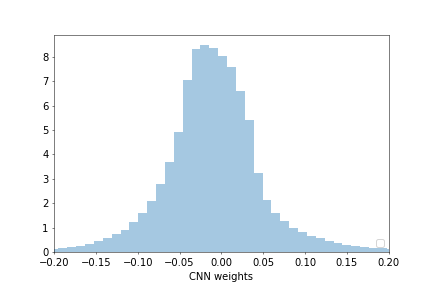

In [33]:
_, ax = plt.subplots(1, 1)
xlim = (-1, 1)
dist_ret = sns.distplot(weight_cnn.flatten(), ax=ax, bins=100, kde=False, norm_hist=True)
ax.set_xlabel("CNN weights")
gauss_pdf = make_pdf(stats.norm, stats.norm.fit(weight_cnn), start=xlim[0], end=xlim[1])
#sns.lineplot(data=gauss_pdf, label="gaussian_fit", ax=ax)
student_pdf = make_pdf(stats.t, stats.t.fit(weight_cnn), start=xlim[0], end=xlim[1])
#sns.lineplot(data=student_pdf, label="student-t_fit", ax=ax)
ax.legend(loc="lower right")
ax.set_xlim((-0.2, 0.2))

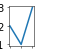

In [34]:
fig = plt.figure(figsize=(fig_width,fig_width*2.3/3))

gs = plt_gridspec.GridSpec(1, 2)

ax = fig.add_subplot(gs[0, 0])
ax.plot([1,2,3], [2,1,3])

In [35]:
plt.rcParams["font.size"]

10.0

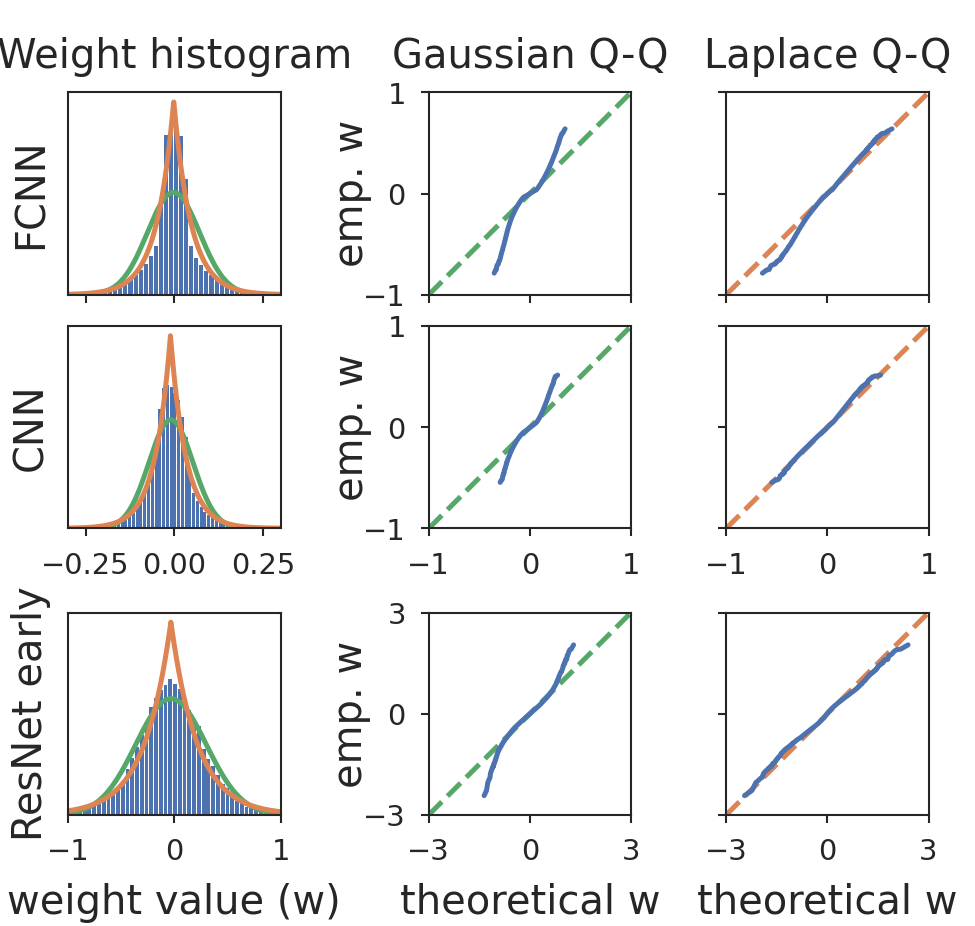

In [237]:
import matplotlib.gridspec as plt_gridspec

sns.set(context="paper", style="ticks", font_scale=1.0)
plt.rcParams["font.sans-serif"].insert(0, "DejaVu Sans")

colors = {
    "laplace": "C1",
    "gaussian": "C2",
    "student-t": "C3",
}


plt.rcParams.update({
    "font.family": "sans-serif",  # use serif/main font for text elements
    "text.usetex": False,     # use inline math for ticks
    "pgf.rcfonts": False,     # don't setup fonts from rc parameters
    "font.size": 10,
    "axes.linewidth": 0.5,
    'ytick.major.width': 0.5,
    'xtick.major.width': 0.5,
    'ytick.major.size': 2,
    'xtick.major.size': 2,
    "ytick.major.left": True,
    "figure.dpi": 300,
})

fig_width_pt = 234.8775
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches

width_ratios = [2.0, .2, 1.9, 1.9]

fig = plt.figure(figsize=(fig_width,fig_width*(width_ratios[-1]/sum(width_ratios) 
                                              )*3))
gridspec = plt_gridspec.GridSpec(figure=fig, nrows=4, ncols=4,
                                 bottom=0.12, left=0.03, right=0.99, top=0.9, hspace=0.2, wspace=0.1,
                                width_ratios=width_ratios, height_ratios=[1.9, 1.9, 0.2, 1.9])

wvalue = "emp. w"
resnet_label = "ResNet early"
for i, (ylabel, weights) in enumerate([("FCNN", weight_dnn), ("CNN", weight_cnn),
                                     (resnet_label, weight_googleresnet)]):
    if i == 2:
        i = 3
        xlim = (-1, 1)
        lim = 3
    else:
        xlim = (-0.3, 0.3)
        lim = 1

    ax = fig.add_subplot(gridspec[i, 0])
    hist(ax, weights.ravel())
    if False: #ylabel == resnet_label:
        t_pdf = make_pdf(stats.t, stats.t.fit(weights.ravel()), start=xlim[0], end=xlim[1])
        ax.plot(t_pdf.index, t_pdf.values, label="T fit", alpha=1, color=colors["student-t"])
    else:
        gauss_pdf = make_pdf(stats.norm, stats.norm.fit(weights.ravel()), start=xlim[0], end=xlim[1])
        ax.plot(gauss_pdf.index, gauss_pdf.values, label="Gaussian fit", alpha=1, color=colors["gaussian"])

    laplace_pdf = make_pdf(stats.laplace, stats.laplace.fit(weights.ravel()), start=xlim[0], end=xlim[1])
    ax.plot(laplace_pdf.index, laplace_pdf.values, label="Laplace fit", alpha=1, color=colors["laplace"])
    ax.set_ylabel(ylabel)
    if i == 0:
        ax.set_title("Weight histogram")
    if i==3:
        ax.set_xlabel("weight value (w)")
    ax.set_xlim(xlim)
    ax.tick_params(left=False, labelleft=False, bottom=True, labelbottom=(i != 0), labelsize="x-small")

    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect((x1-x0)/(y1-y0) * width_ratios[2]/width_ratios[0] )

    ax = fig.add_subplot(gridspec[i, 2])
    ax.set_xlim((-lim, lim))
    ax.set_ylim((-lim, lim))
    if False: #ylabel == resnet_label:
        ax.plot([-lim, lim], [-lim, lim], linestyle="--", alpha=1, color=colors["student-t"])
        qqplot(ax, weights.ravel(), stats.t)
    else:
        ax.plot([-lim, lim], [-lim, lim], linestyle="--", alpha=1, color=colors["gaussian"])
        qqplot(ax, weights.ravel(), stats.norm)
    ax.set_xticks([-lim, 0, lim])
    ax.set_yticks([-lim, 0, lim])
    if i==0:
        ax.set_title("Gaussian Q-Q")
    ax.set_aspect('equal')
    ax.set_ylabel(wvalue, labelpad=-2)
    if ylabel == resnet_label:
        ax.set_xlabel("theoretical w")
        #ax.set_title("Student-t Q-Q")
    ax.tick_params(labelsize="x-small", labelbottom=(i != 0))

    ax = fig.add_subplot(gridspec[i, 3])
    ax.set_xlim((-lim, lim))
    ax.set_ylim((-lim, lim))
    ax.plot([-lim, lim], [-lim, lim], linestyle="--", alpha=1, color=colors["laplace"])
    qqplot(ax, weights.ravel(), stats.laplace)
    ax.set_xticks([-lim, 0, lim])
    ax.set_yticks([-lim, 0, lim])
    if i==0: # or ylabel == resnet_label:
        ax.set_title("Laplace Q-Q")
    ax.set_aspect('equal')
    ax.tick_params(labelsize="x-small", labelbottom=(i != 0), labelleft=False)
    if ylabel == resnet_label:
        ax.set_xlabel("theoretical w")

fig.savefig("../figures/210203-qqplots-allgaussian.pdf")

,prior,temperature,error_mean,error_stderr
0,student-t,0.001,0.02750,0.000348
1,student-t,0.010,0.02710,0.000392
2,student-t,0.030,0.02616,0.000519
3,student-t,0.100,0.02636,0.000459
4,student-t,0.300,0.02510,0.000321
5,student-t,1.000,0.01886,0.000169
6,laplace,0.001,0.02192,0.000476
7,laplace,0.010,0.02182,0.000280
8,laplace,0.030,0.02220,0.000633
9,laplace,0.100,0.02020,0.000581


In [157]:
weight_dnn.min(), weight_dnn.max()

(-0.7868374, 0.6394576)

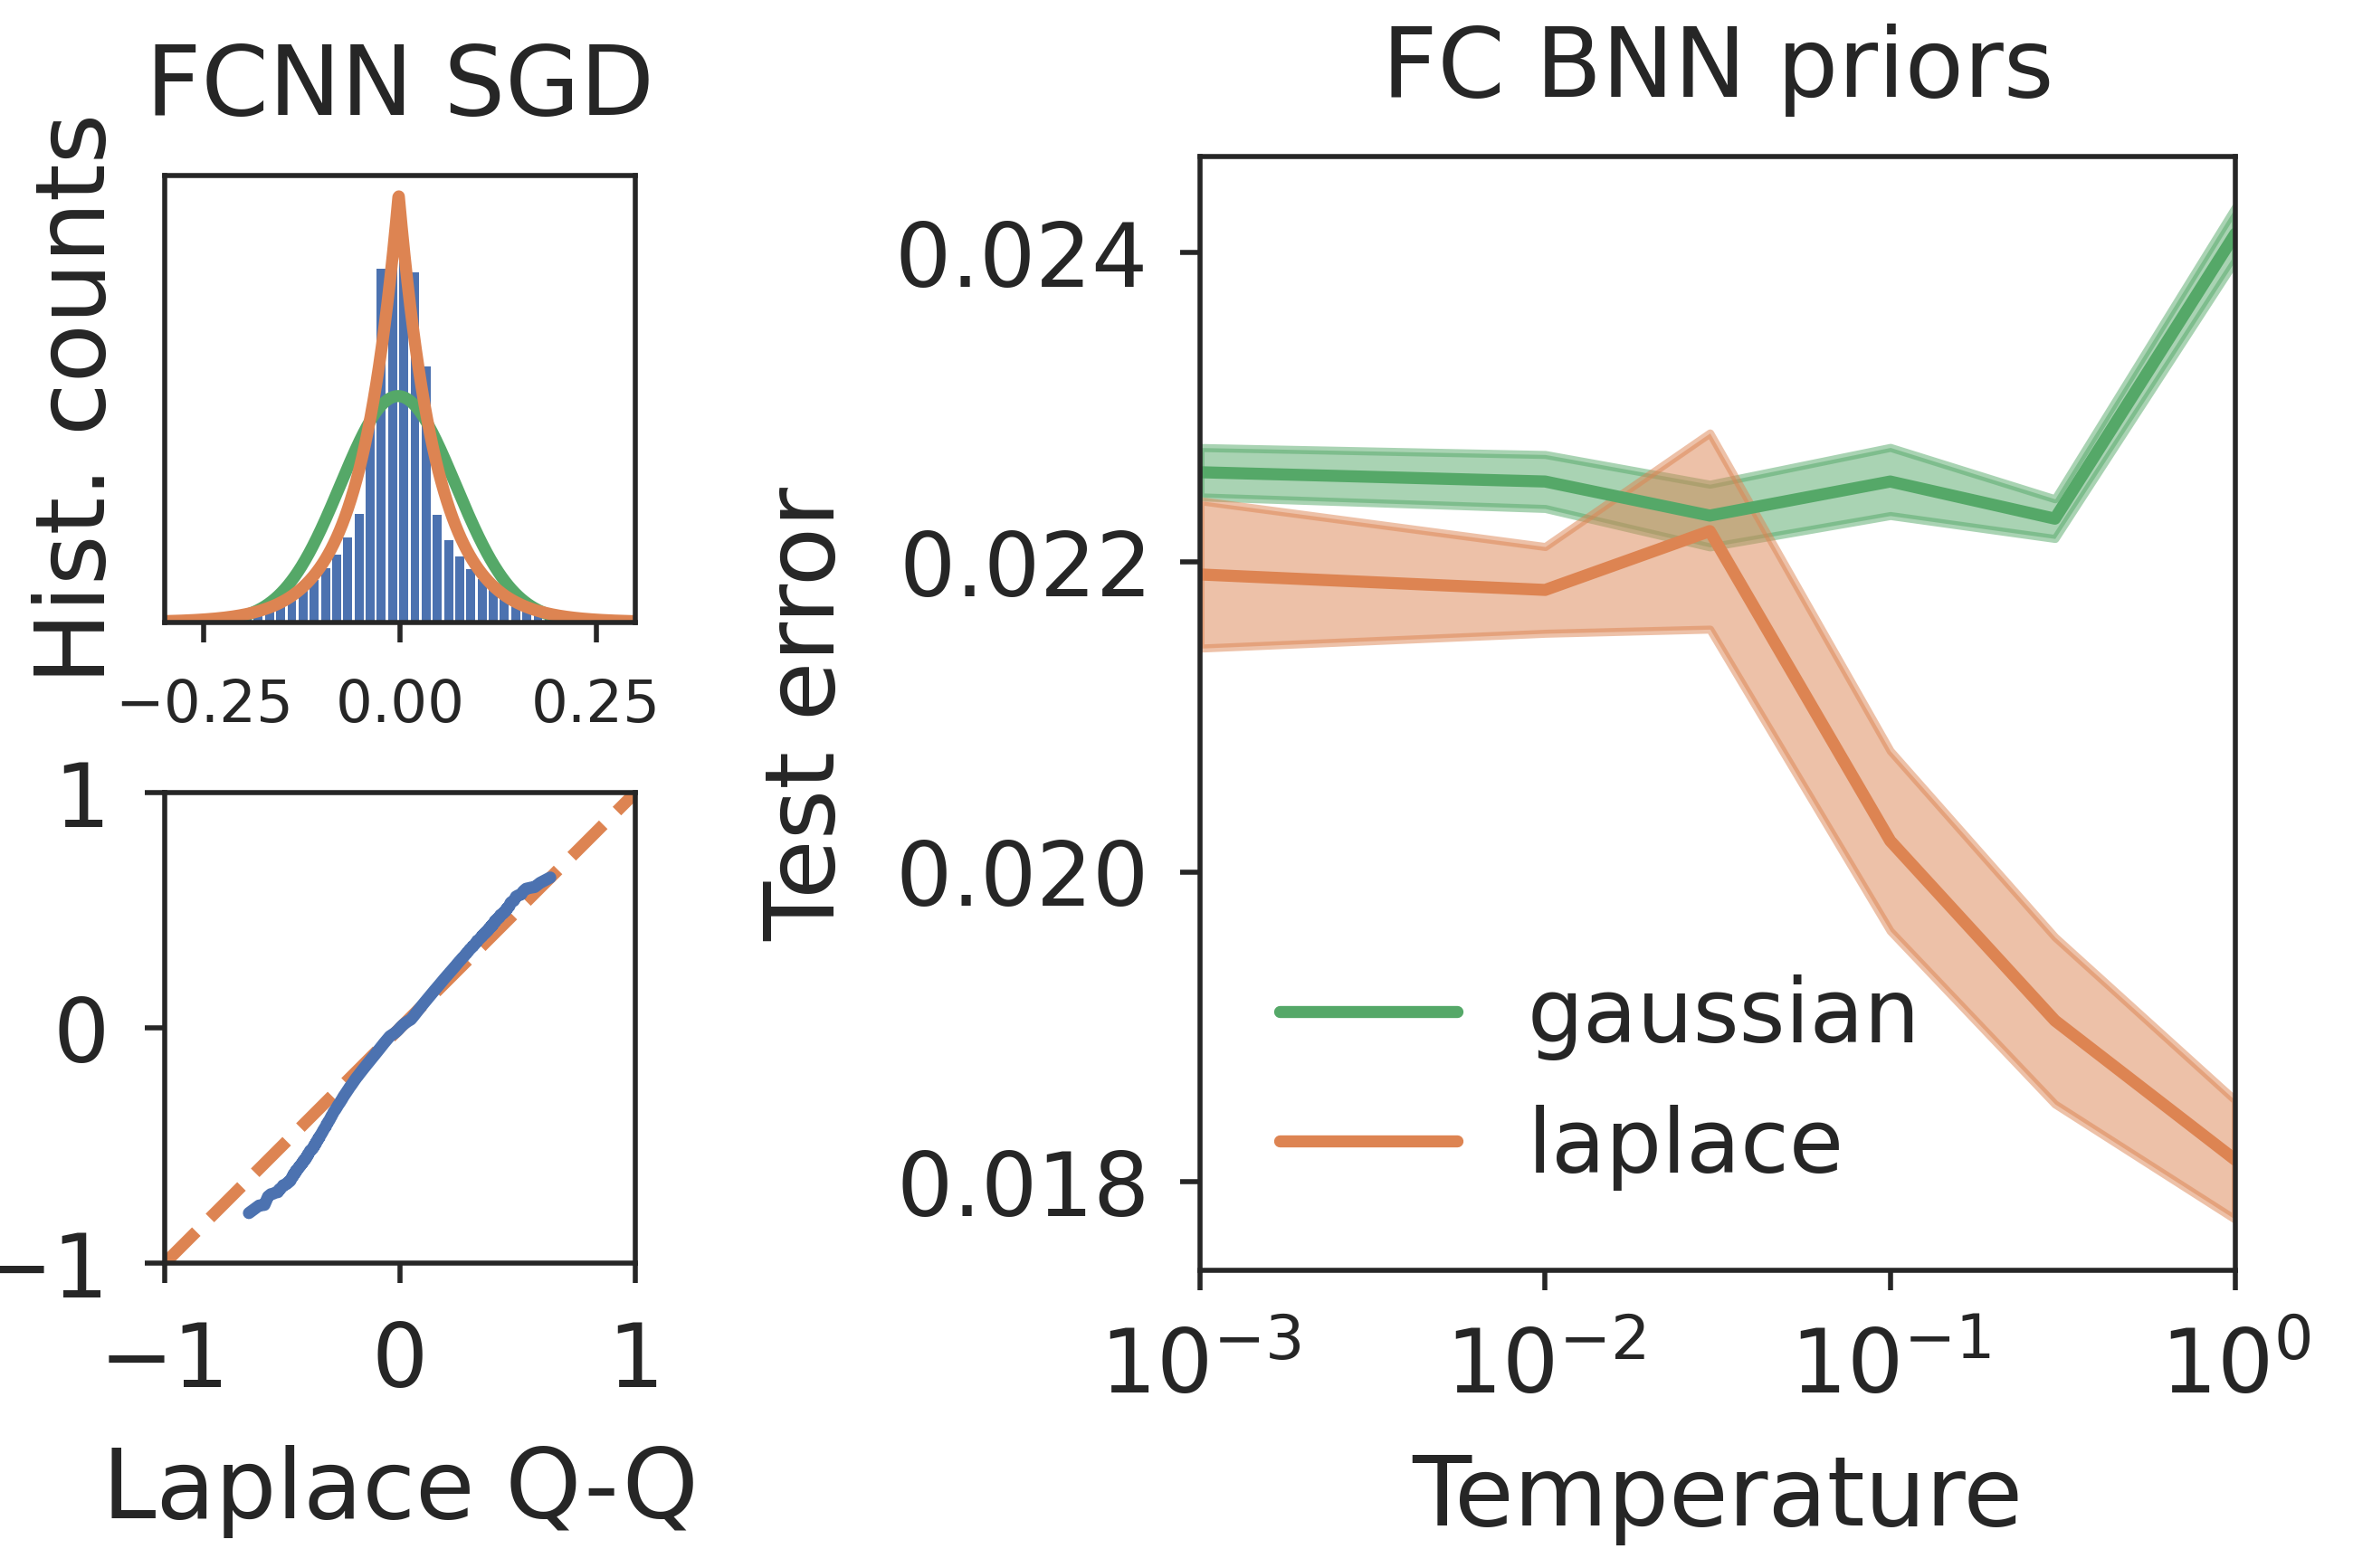

In [240]:
import matplotlib.gridspec as plt_gridspec

colors = {
    "laplace": "C1",
    "gaussian": "C2",
    "student-t": "C0",
}

sns.set(context="paper", style="ticks", font_scale=1.0)
plt.rcParams["font.sans-serif"].insert(0, "DejaVu Sans")

plt.rcParams.update({
    "font.family": "sans-serif",  # use serif/main font for text elements
    "text.usetex": False,     # use inline math for ticks
    "pgf.rcfonts": True,     # don't setup fonts from rc parameters
    "font.size": 10,
    "axes.linewidth": 0.5,
    'ytick.major.width': 0.5,
    'xtick.major.width': 0.5,
    'ytick.major.size': 2,
    'xtick.major.size': 2,
    "ytick.major.left": True,
    'ytick.minor.left': False,
    'xtick.minor.bottom': False,
    "figure.dpi": 800,
})

fig_width_pt = 234.8775
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches

fig = plt.figure(figsize=(fig_width,fig_width*2/3))
gridspec = plt_gridspec.GridSpec(figure=fig, nrows=2, ncols=2,
                                 bottom=0.19, left=0.07, right=0.95, top=0.9, hspace=0.3, wspace=0.75,
                                 width_ratios=[1, 2.2], height_ratios=[1, 1])

lim = 1.0
xlim = (-0.3, 0.3)

ax = fig.add_subplot(gridspec[0, 0])
ax.set_xlim(xlim)

hist(ax, weight_dnn.ravel())
gauss_pdf = make_pdf(stats.norm, stats.norm.fit(weight_dnn.ravel()), start=xlim[0], end=xlim[1])
ax.plot(gauss_pdf.index, gauss_pdf.values, label="Gaussian fit", alpha=1, color=colors["gaussian"])

laplace_pdf = make_pdf(stats.laplace, stats.laplace.fit(weight_dnn.ravel()), start=xlim[0], end=xlim[1])
ax.plot(laplace_pdf.index, laplace_pdf.values, label="Laplace fit", alpha=1, color=colors["laplace"])

ax.set_title("FCNN SGD")
ax.set_ylabel("Hist. counts")
ax.tick_params(left=False, labelleft=False, labelbottom=True, labelsize='xx-small')


x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect((x1-x0)/(y1-y0) * width_ratios[2]/width_ratios[0] )

ax = fig.add_subplot(gridspec[1, 0])
ax.set_xlim((-lim, lim))
ax.set_ylim((-lim, lim))
ax.plot([-lim, lim], [-lim, lim], linestyle="--", alpha=1.0, color=colors["laplace"])
qqplot(ax, weight_dnn.ravel(), stats.laplace)
ax.set_xlabel("Laplace Q-Q")
ax.set_aspect('equal')

ax = fig.add_subplot(gridspec[:, 1])
df = pd.read_pickle("mnist_fcnn_errors.pkl")

for color_i, prior_name in enumerate(["gaussian", "laplace"]):
    this_df = df[df["prior"] == prior_name ].sort_values("temperature")
    x = this_df["temperature"].values
    
    line, *_ = ax.plot(x, this_df["error_mean"].values, label=prior_name, color=colors[prior_name])

    C = line.get_color()
    lower = this_df["error_mean"].values - this_df["error_stderr"].values
    upper = this_df["error_mean"].values + this_df["error_stderr"].values
    ax.fill_between(x, lower, upper, alpha=0.5, color=C)
legend = ax.legend(frameon=False)
ax.set_ylabel("Test error")
ax.set_xlim((1e-3, 1))
ax.set_xscale("log")
ax.ticklabel_format(axis='y', style='plain', scilimits=(0, 0), useMathText=True)
ax.set_xlabel("Temperature")
ax.set_title("FC BNN priors")


fig.savefig("../figures/210203-teaser.pdf")

legend False


/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


legend False
legend False
legend False
legend True


/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

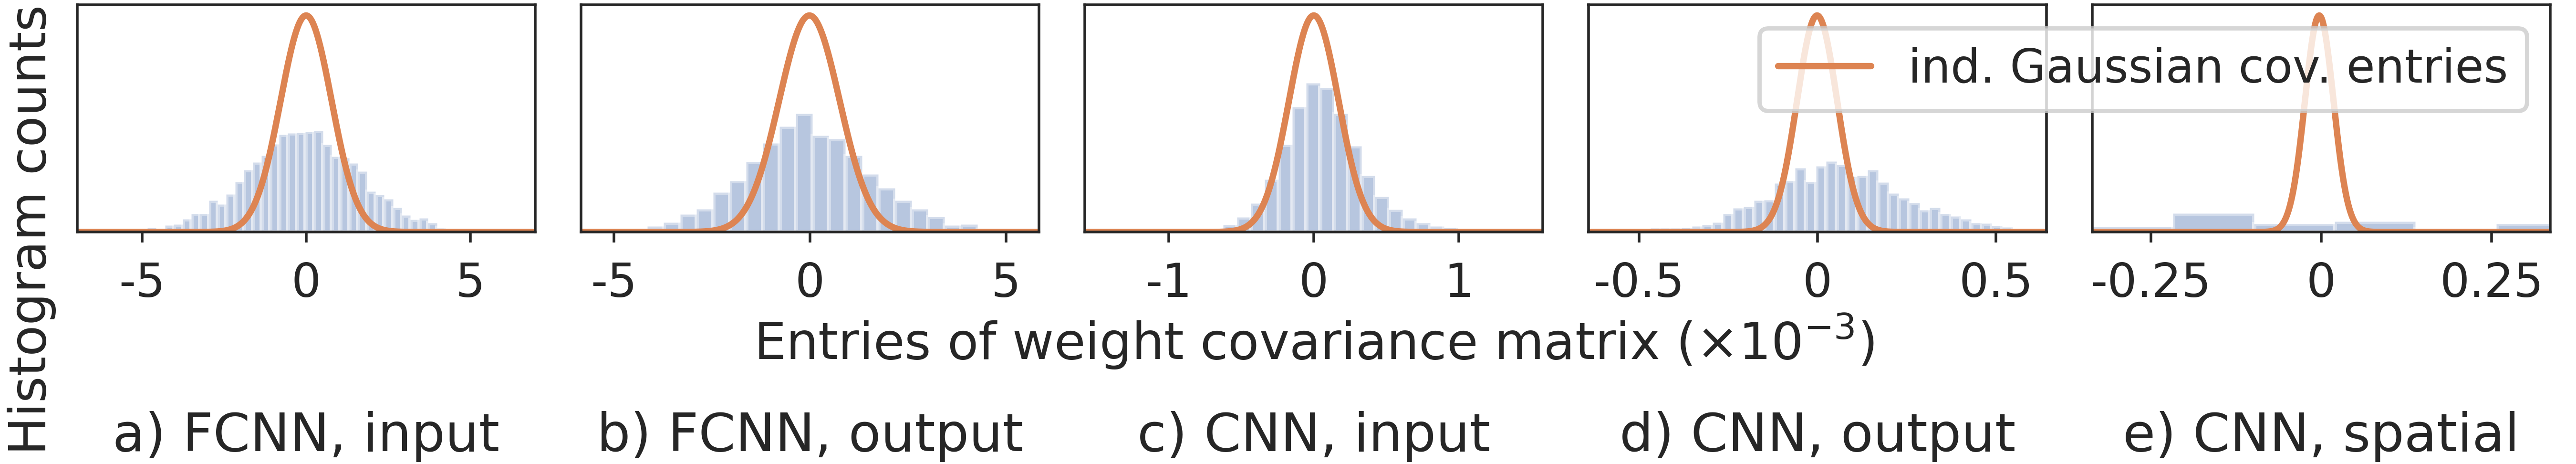

In [235]:
sns.set(context="paper", style="ticks", font_scale=1.0)

plt.rcParams["font.sans-serif"].insert(0, "DejaVu Sans")

plt.rcParams.update({
    "font.family": "sans-serif",  # use serif/main font for text elements
    "text.usetex": False,     # use inline math for ticks
    "pgf.rcfonts": True,     # don't setup fonts from rc parameters
    "font.size": 10,
    "axes.linewidth": 0.5,
    'ytick.major.width': 0.5,
    'ytick.major.size': 2,
    'xtick.major.width': 0.5,
    'xtick.major.size': 2,
})

def plot_covar_offdiagonals_reduced(weights_reshaped, rowvar, title=None, num_bins=50, ax=None, legend=True):
    print("legend", legend)
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,3))
    else:
        fig = None
    vmin = np.min([np.cov(weight, rowvar=rowvar) for weight in weights_reshaped.values()])
    xlim = (vmin,-vmin)
    for name in ["empirical", "gaussian"]:
        weight = weights_reshaped[name]
        covar = np.cov(weight, rowvar=rowvar)
        offdiagonals = covar[np.where(~np.eye(covar.shape[0],dtype=bool))]
        if name == "empirical":
            sns.distplot(offdiagonals, ax=ax, bins=num_bins, kde=False, norm_hist=True)
            ax.set_xlabel(name)
            ax.set_xlim(xlim)
        else:
            gauss_pdf = make_pdf(stats.norm, stats.norm.fit(offdiagonals), start=xlim[0], end=xlim[1])
            ax.plot(gauss_pdf.index, gauss_pdf.values, label=r"ind. Gaussian cov. entries")
            if legend:
                ax.legend(loc="upper right")
        ax.tick_params(left=False, labelleft=False)

    if fig is not None:
        if title is not None:
            fig.suptitle(title)
            fig.tight_layout(rect=[0, 0, 1, 0.97])
        else:
            fig.tight_layout()
    return fig

-                        gridspec_kw=dict(bottom=0.50, left=0.03, right=0.99, top=0.99, hspace=0.1, wspace=0.1))

# fully connected NN
key = "net.module.2.weight_prior.p"
exp_name = "mnist_classificationdensenet"
def reshape_input_covar(weights):
    return reshape_weight(weights, lambda w: w.transpose((0, 1, 2)).reshape((w.shape[0]*w.shape[1], -1)))
def reshape_output_covar(weights):
    return reshape_weight(weights, lambda w: w.transpose((0, 2, 1)).reshape((-1, w.shape[1])))

ax = axes[0]
plot_covar_offdiagonals_reduced(reshape_input_covar(all_samples[exp_name][key]),
                                rowvar=False, num_bins=50, ax=ax, legend=False)
ax.set_xticks([-0.005, 0, 0.005])
ax.set_xticklabels(["-5", "0", "5"])
ax.text(0.5, -0.9, r"a) FCNN, input", horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
ax.set_xlabel("")
ax.set_ylabel("Histogram counts", horizontalalignment="right", position=(0, 1))


ax = axes[1]
plot_covar_offdiagonals_reduced(reshape_output_covar(all_samples[exp_name][key]),
                                rowvar=False, num_bins=30, ax=ax, legend=False)
ax.set_xticks([-0.005, 0, 0.005])
ax.set_xticklabels(["-5", "0", "5"])
ax.text(0.5, -0.9, r"b) FCNN, output", horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
ax.set_xlabel("")


# Convolutional NN
key = "net.module.4.weight_prior.p"
exp_name = "mnist_classificationconvnet"

def reshape_input_covar(weights):
    return reshape_weight(weights, lambda w: w.transpose((0, 1, 2, 3, 4)).reshape((w.shape[0]*w.shape[1], -1)))
def reshape_output_covar(weights):
    return reshape_weight(weights, lambda w: w.transpose((0, 2, 3, 4, 1)).reshape((-1, w.shape[1])))
ax = axes[2]
plot_covar_offdiagonals_reduced(reshape_input_covar(all_samples[exp_name][key]),
                                rowvar=False, num_bins=50, ax=ax, legend=False)
ax.set_xticks([-0.001, 0, 0.001])
ax.set_xticklabels(["-1", "0", "1"])
ax.text(0.5, -0.9, r"c) CNN, input", horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
ax.set_xlabel(r"Entries of weight covariance matrix $(\times 10^{-3})$", labelpad=1)

ax = axes[3]
plot_covar_offdiagonals_reduced(reshape_output_covar(all_samples[exp_name][key]),
                                rowvar=False, num_bins=50, ax=ax, legend=False)
ax.text(0.5, -0.9, r"d) CNN, output", horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
ax.set_xticks([-0.0005, 0, 0.0005])
ax.set_xticklabels(["-0.5", "0", "0.5"])
ax.set_xlabel("")

weights_reshaped = {name : weight.reshape(-1, 9) for name, weight in reshape_weight(all_samples[exp_name][key], lambda w: w).items()}

ax = axes[4]
plot_covar_offdiagonals_reduced(weights_reshaped,
                                rowvar=False, num_bins=15, ax=ax, legend=True)
ax.set_xticks([-0.00025, 0, 0.00025])
ax.set_xticklabels(["-0.25", "0", "0.25"])
ax.text(0.5, -0.9, r"e) CNN, spatial", horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
ax.set_xlabel("")
fig.savefig("../figures/210125-corr-hist.pdf")

In [ ]:
np.sum(np.sort(np.abs(weight_cnn.flatten())) < 1e-8)

In [ ]:
len(weight_cnn.flatten())

In [ ]:
_, xs, ys = empirical_cdf(weight_dnn)
plt.plot(xs, ys)
#plt.xlim((-0.01, 0.01))

In [ ]:
w = np.copy(weight_cnn.flatten())
sorted_w = np.sort(w)

x = np.stack([sorted_w]*2, axis=1).flatten()
y = np.stack([np.arange(0, len(w)), np.arange(1, len(w)+1)], axis=1).flatten()

plt.plot(x, y)

In [ ]:
w = np.copy(weight_dnn.flatten())
sorted_w = np.sort(w)

x = np.stack([sorted_w]*2, axis=1).flatten()
y = np.stack([np.arange(0, len(w)), np.arange(1, len(w)+1)], axis=1).flatten()

plt.plot(x, y)

In [ ]:
np.arange(0, 0.1, 0.005)

In [ ]:
fig.savefig(f"../figures/200917_mnist_vs_200922_mnist_cnn_weight_dists.pdf", bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
weights = {"dnn": weight_dnn.flatten(), "cnn": weight_cnn.flatten()}
for param, weight in weights.items():
    print(f"Normality tests for {param}:")
    print(f"Mean = {weight.mean():.2f}, std = {weight.flatten().std():.2f}")
    print("D'Angostino: statistic = {0:.2f}, p-value = {1:.2e}".format(*stats.normaltest(weight)))
    print("Shapiro: statistic = {0:.2f}, p-value = {1:.2e}".format(*stats.shapiro(np.random.choice(weight, size=min(5000, len(weight)), replace=False))))